# **Setup**

In [ ]:
!pip install ahrs
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 8.9MB/s 
     |████████████████████████████████| 204kB 8.3MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61



```
from google.colab import drive
drive.mount('/content/drive')
```

It's more convenient to use the UI for mounting Google Drive.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from fastai.tabular.all import *

In [ ]:
import ahrs.common.orientation
from ahrs.common.orientation import *

In [ ]:
from scipy.spatial.transform import Rotation as R

In [ ]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

# **FillNet Research Notebook #1**

### **Scope**
1.   Data Hunting ✅
2.   Data Engineering ✅
3.   Exploring the API ✅

### **Coming Up**
- Prototyping with fastai defaults (parameters, loss, activation).
- Determine loss & output data type (axis-angle, rotation matrix, quaternion)

## **1. Data Hunting**

First reading of [research paper](https://calciferzh.github.io/files/zhou2020monocular.pdf). 

Learned that: datasets used to train minimal-hand are of [3D-annotated, 2D-annotated, Motion Capture]; that loss functions and training process are defined at a **fairly** complex level of understanding; that for headfirst prototyping purposes, MoCap data is solely sufficient. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
poses = np.load('./drive/MyDrive/make/Hand/handpose/mano_poses_v1_0/handsOnly_REGISTRATIONS_r_lm___POSES___R.npy')

## **2. Data Engineering**

In [ ]:
poses.shape

(1554, 45)

In [ ]:
poses

array([[-0.16860745,  0.12699952, -0.13889985, ...,  0.01547092,
         0.13283119, -0.28242049],
       [-0.00193313, -0.07309378, -0.40431598, ...,  0.71033571,
        -0.33469082,  0.69701037],
       [-0.11891754,  0.02193251, -0.28468175, ...,  0.47163935,
        -0.42118364, -0.0590474 ],
       ...,
       [-0.02013238,  0.17143567,  0.19258048, ...,  0.85280302,
        -0.91707561,  0.72095209],
       [ 0.06468249,  0.07182106, -0.04767938, ...,  0.71936823,
        -0.32261746, -0.09735304],
       [-0.01905158,  0.21760531,  0.14869293, ...,  0.29565598,
         0.00755491, -0.22863567]])

In [ ]:
class MANOHandJoints:
  n_joints = 16

  labels = [
    'I0', 'I1', 'I2', #2
    'M0', 'M1', 'M2', #5
    'L0', 'L1', 'L2', #8
    'R0', 'R1', 'R2', #11
    'T0', 'T1', 'T2', #14  
  ]

mano = MANOHandJoints()

Per Zhao, the MANO way of handling joints is different from how he thinks about them, so manually, he added the fingertip joints. It'll be great to catch what he said exactly.

One question that must be cleared is: **"Are the joint information entirely local? or does it include some sort of information based upon the global origin pose?"** To my intuition, it does not matter what sort of representation is used - locality/globality is independent from that. 

My weak prediction says that yes, these are local. Because the parent-child relationship is explicitly stated from the code and paper of minimal-hand (where it mentions MANO).

## **3. Exploring the API**

### **3.1. Before We Start**

Multi-output nature of our problem poses a problem for FastAI–we lack a well-documented example. (But it seems possible, even without getting hands dirty with fastai's mid-level API.) Let's look for advanced chapters of the FastBook for possible breakthroughs.

Okay, FastBook doesn't discuss multi-output cases. Therefore, I've searched up for relevant discussions:
   - https://forums.fast.ai/t/fastai-multi-value-regression-with-images-as-input/43866/2
   - https://forums.fast.ai/t/i-dont-know-how-to-make-a-multi-output-model-for-structured-data-using-fastai-library/17891
   - https://forums.fast.ai/t/tabular-data-with-multiple-outputs/34251
   - https://forums.fast.ai/t/multiple-outputs/69137

as well as relevant blog posts:
   - https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855
   - https://getpocket.com/read/2928902383
   - https://getpocket.com/read/3093587187


### **3.2. 스크래치노트**

좋은 소식과 나쁜 소식—먼저, joint orientation은 꽤나 수학적인 개념이라서 데이터 pre-processing이 거의 필요 없다시피 함. TabularPandas같은 wrapper API를 배울 필요도 없고. 하지만, fastai API 자체가 생각만큼 간단하지 않으며, output이 곧 loss term이 되는 기본값이 axis-angle representation과 얼마나 부합할지... 느낌상으론, 잘되지 않을듯. 결과적으로 논문을 어떻게 오늘 안에 완성할지 모르겠다. 성공적으로 제출하는 시나리오가 있다면 1. 예상보다 결과가 너무 좋아서 개같이 만든 프로토타입을 그냥 제출; 2. 아무리 봐도 실패라서 그냥 실패한걸로 작성.

일단 09_tabular에서 쓸만한 코드를 죄다 집어와보자! (약간의 수정을 거침)


```
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

to = TabularPandas(df_final, procs, cat, cont, splits=splits, y_names=dep_var)

dls = to.dataloaders(1024)

learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], n_out=1, loss_func=F.mse_loss)

learn.fit_one_cycles(5, 1e-2)

learn.save('neuralnetwork')
```

### **3.3. Attempt**

In [ ]:
cols = [i+'_'+j for i in mano.labels for j in ['a','b','c']]
input_cols = [cols[i] for i in [0,1,2, 9,10,11, 18,19,20, 27,28,29, 36,37,38]] # proximal
# input_cols = [cols[i] for i in [3,4,5, 12,13,14, 21,22,23, 30,31,32, 39,40,41]] # intermediate
# input_cols = [cols[i] for i in [6,7,8, 15,16,17, 24,25,26, 33,34,35, 42,43,44]] # distal

In [ ]:
df = pd.DataFrame(poses, columns=cols)

In [ ]:
train_idx = np.where(df[:1243])[0]
valid_idx = np.where(df[1243:])[0]

splits = (list(train_idx),list(valid_idx))

In [ ]:
to = TabularPandas(df, procs=None, cat_names=None, cont_names=input_cols, y_names=cols, splits=splits) # cont_names=cols는 어떨까.

In [ ]:
dls = to.dataloaders(1024)

In [ ]:
y = to.train.y
y.min(), y.max()

(-0.363310843706131, 0.617450475692749)

In [ ]:
learn = tabular_learner(dls, layers = [2048, 1024, 512], y_range=(-1, 1), n_out=45, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=6.30957365501672e-05)

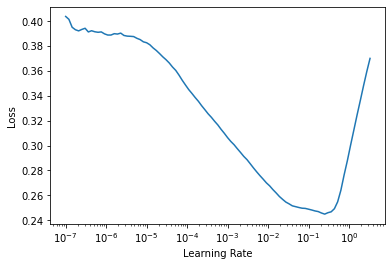

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(n_epoch=22, lr_max=1e-2)

epoch,train_loss,valid_loss,time
0,0.178248,0.122754,00:00
1,0.119230,0.080251,00:00
2,0.086979,0.063281,00:00
3,0.071509,0.060446,00:00
4,0.064973,0.057768,00:00
5,0.061627,0.057545,00:00
6,0.064625,0.057488,00:00
7,0.060232,0.055088,00:00
8,0.057832,0.054789,00:00
9,0.057115,0.054325,00:00


In [ ]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.23023

아무것도 안건드렸는데도 지혼자 `0.45`까지 올라가는 바람에 그냥 이렇게 놔두고 이동. 

트레이닝 성공적! 역시 비주얼리제이션이 돼야 정확성에 대한 qualitative analysis가 가능해짐.

In [ ]:
learn.save('fillnet_01')

Path('models/fillnet_01.pth')

### **Why is `get_preds` Obscurely Long**?

For some unknown reason, `get_preds` returns `preds` of size `[13995, 45]` instead of the expected `[1554, 45]`. Here is a re-write of the code, only difference being a different output variable size (1 instead of 45); let's check if that makes a difference.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:172: UserWarning: Using a target size (torch.Size([1024, 1])) that is different to the input size (torch.Size([1024, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss_grad = self.loss_func(self.pred, *self.yb)


epoch,train_loss,valid_loss,time
0,0.005475,0.000247,00:00
1,0.001584,0.000177,00:00
2,0.000550,0.000017,00:00
3,0.000220,0.000008,00:00


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:172: UserWarning: Using a target size (torch.Size([683, 1])) that is different to the input size (torch.Size([683, 45])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss_grad = self.loss_func(self.pred, *self.yb)


torch.Size([13995, 45])


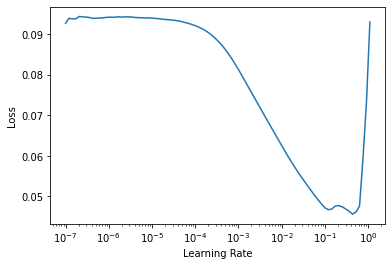

In [ ]:
to_001 = TabularPandas(df, procs=None, cat_names=None, cont_names=input_cols, y_names='I0_a', splits=splits) # cont_names=cols는 어떨까.
dls_001 = to_001.dataloaders(1024)
y_001 = to_001.train.y
y_001.min(), y_001.max()
learn_001 = tabular_learner(dls_001, y_range=(-1, 1), n_out=45, loss_func=F.mse_loss)
learn_001.lr_find()
learn_001.fit_one_cycle(n_epoch=4, lr_max=1e-1)

preds_001,targs_001 = learn_001.get_preds()
r_mse(preds_001,targs_001)
print(preds_001.shape)

동일하게 13995 사이즈이므로 무언가 문제가 있다 생각이 된다. 하지만 솔직히 이거 트러블슈팅할 시간 없다 그냥 내자

# **FillNet Research Notebook #2**

### **Scope**
0. Streamlining fastai ✅
1. Loss Function Variation ❎
2. Hyperparameter Variation
3. Input Data Variation (experimental variable) ✅

### **Coming Up**
- Statistical analysis for accuracy
  - current idea: [mean absolute error](https://summer.gatech.edu/ignite-tentative-course-list-2021/)
  - for position and angle

## **1. Loss Function Variation**

**Process**:
- axis-angle representation -> quaternion representation
- learn
- create predictions, targets
- revert predictions, targets to axis-angle
- evaluate root-mean-squared error (RMSE)

and then repeat, for rotation matrix representation

But before doing that, let's read how Zhao's done it for minimal-hand. This man's smart asf, and probably there lies a clever reasoning behind how and why he does what he does. 

Zhao defines joint orientation in **quaternions**. He defines a loss function comprised of four terms: 1. the cosine of angle difference (computed directly from quaternions), 2. direct quaternion difference, 3. (??? data pulled from DetNet to add robustness against DetNet-borne noise), 4. quaternion norm (to "softly constrain into normalized quaternions").

Thought Food: It's interesting what effect the direct quaternion difference loss term has on the overarching performance of the network. Normally, wouldn't one think that the angle difference is what counts?

In [ ]:
class MANOHandJoints:
  n_joints = 15

  labels = [
    'I0', 'I1', 'I2', #2
    'M0', 'M1', 'M2', #5
    'L0', 'L1', 'L2', #8
    'R0', 'R1', 'R2', #11
    'T0', 'T1', 'T2', #14  
  ]

mano = MANOHandJoints()


def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

cols_axang = [i+'_'+j for i in mano.labels for j in ['a','b','c']]
cols_quat = [i+'_'+j for i in mano.labels for j in ['q', 'x', 'y', 'z']]

def select_cols(cols, selection): return [cols[i] for i in selection]

def split(df, ratio): 
    marker = int(poses.shape[0] * ratio)
    train_idx = np.where(df[:marker])[0]
    valid_idx = np.where(df[marker:])[0]
    splits = (list(train_idx),list(valid_idx)); return splits

In [ ]:
def ml(cols, input_cols, data, split_ratio):
    # data initialization
    df = pd.DataFrame(data, columns=cols)
    # further initialization
    to = TabularPandas(df, procs=None, cat_names=None, cont_names=input_cols, y_names=cols, splits=split(df, split_ratio))
    # dataloader
    dls = to.dataloaders(1024)

    y = to.train.y
    y.min(), y.max()

    learn = tabular_learner(dls, y_range=(-1, 1), n_out=data.shape[1], loss_func=F.mse_loss)
    learn.lr_find()
    learn.fit_one_cycle(n_epoch=4, lr_max=1e-1)

    preds,targs = learn.get_preds()
    return r_mse(preds,targs)

```
input_cols = select_cols(cols_axang, [1, 4, 7, 10, 13])

ml(input_cols, poses_quat, split_ratio=0.8)
```

In [ ]:
poses = np.load('./drive/MyDrive/make/Hand/handpose/mano_poses_v1_0/handsOnly_REGISTRATIONS_r_lm___POSES___R.npy')

In [ ]:
poses_quat = np.zeros(shape=[poses.shape[0], 60])

for row in range(poses.shape[0]):
    for i in range(15): 
        iii, iiii = i*3, i*4
        axang = [poses[row,iii+0], poses[row,iii+1], poses[row,iii+2]]
        quat = axang2quat(axis=[axang[0], axang[1], 0], angle=axang[2]) # 3-element axang to 4-element axang, how?
        
        poses_quat[row, iiii+0] = quat[0]
        poses_quat[row, iiii+1] = quat[1]
        poses_quat[row, iiii+2] = quat[2]
        poses_quat[row, iiii+3] = quat[3]

epoch,train_loss,valid_loss,time
0,0.059994,0.019472,00:00
1,0.026106,0.014383,00:00
2,0.014390,0.007806,00:00
3,0.009615,0.006923,00:00


0.083207


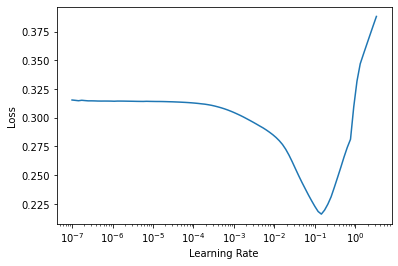

In [ ]:
input_cols = select_cols(cols_quat, [4,5,6,7, 16,17,18,19, 28,29,30,31, 40,41,42,43, 52,53,54,55])

print(ml(cols_quat, input_cols, poses_quat, split_ratio=0.8))

In [ ]:
len(cols_quat)

60

In [ ]:
poses_quat.shape

(1554, 60)

## **타임!**

### **work still required for paper**
- Completion of model
  - Loss function for training 
    - effectively a validation set: semi-visible to the model but necessary for model
  - Accuracy function for decision-making
    - effectively a test set: invisible to the model, but necessary for me
- Qualitative analysis method
  - = visualization
  - Pose estimation is an intrinsically visual task; we humans represent it in visual forms


## 공부를 좀 했다

배운점:
- 손해함수 정의하는거 은근 쉽다; 거의 코드의 탈을 쓴 수학. `포워드`에선 손해를 계산하여 반환한다. 예시에선 거의 모든 계산을 `반환` 키워드 후에 한번에 통짜로 하는데, 내 생각엔 경사하강을 위해선 함수의 미분을 프로그램이 알아야 하기때문에, 가장 난해하지 않은 방식으로, 컴퓨터가 미분값을 알 수 있게 계산해야 한다 추정했는데, 이게 맞는지는 아직 모르겠다. 
  - Zhao가 쿼터니온을 사용한 계기를 설명하며 "삼각함수를 사용하지 않으므로 non-injective하여 트레이닝에 우월하다나 뭐라나" 그랬는데, 아무쪼록 이거랑 관련되었을 듯. 암튼 Zhao의 손해함수를 모방하는 것이 좋은 결과를 만들거란 것을 아직 확신.
- `activation`과 `decode` 함수를 정의해야 하지만, 사실상 API적 껍데기이다. 단순히 [`softmax`](https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d)와 [`argmax`](https://machinelearningmastery.com/argmax-in-machine-learning/)를 반환하면 된다. 
- [FastBook 손해함수 예시](https://docs.fast.ai/tutorial.imagenette#Changing-the-loss-function)

### 공부를 더 함

**Why can’t we use accuracy as a loss function?**

According to [sinclair](https://mjwoo001.medium.com/why-cant-we-use-accuracy-as-a-loss-function-c15c54ca2e0a): "A loss function must be differentiable to perform gradient descent. It seems like you’re trying to measure some sort of 1-accuracy. This doesn’t have a derivative, so you can’t use it.

- *gradient descent* : An optimization algorithm used to minimize some function by iteratively moving in the direction of steepest descent as defined by the negative of the gradient. -> This is the way to fine linear and the machine learns it."

그니까 내 직감이 맞았네. 손해함수는 아무거나 떄려박는다고 되는건 아니다. 모델을 향상하려면 미분값이 필요하다. 변수가 2개쯤이라면 brute-forcing하면 되겠지만, 변수가 15개씩 되면 기하급수적으로 계산량이 늘어난다. 

**결론.** The above outline still applies. However: the loss function must be differentiable in addition to "relevant" (in terms of model improvement). 그러니까 인균형한테 물어보는게 역시 맞다. 요지는: 3D orientation에 대한 loss function을 구현하려 한다는 것; Zhao가 만든 예시를 보여주는 것; 각 input variable에 직접적으로 대응하는 미분이 필요할텐데 손해함수 내의 계산이 복잡해지거나 난해해진다면 프로그램은 그것을 처리할 수 있는지, 만약 가능하다면 어떻게인지, 불가능하다면 어떤 가능성이 있을지.

### 이제 쓰자

FastAI Template
```
class LabelSmoothingCE(Module):
    def __init__(self, self.eps = 0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1) #We divide by that size at the return line so sum and not mean
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target.long(), reduction=self.reduction)

    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):    return out.argmax(dim=-1)
```

[Deconstructing `axis=-1`](https://stackoverflow.com/questions/47435526/what-is-the-meaning-of-axis-1-in-keras-argmax)

**Pseudocode**
1. Perform quaternion inverse
2. Perform quaternion multiplication
3. Extract real parts; subtract from 1.


In [ ]:
'''class QuaternionLoss(Module):
    def __init__(self, reduction='mean'): self.reduction = reduction

    def forward(self, output, target):
        c = output.size()[-1]
        quaternion
        for i in range(15): for j in range(4): 
        
        if self.reduction='sum':
            pass
        
        if self.reduction=='mean':
            pass
        
    def activation(self, out): return F.softmax(out, dim=-1)
    def decodes(self, out):       return out.argmax(dim=-1)'''

"class QuaternionLoss(Module):\n    def __init__(self, reduction='mean'): self.reduction = reduction\n\n    def forward(self, output, target):\n        c = output.size()[-1]\n        quaternion\n        for i in range(15): for j in range(4): \n        \n        if self.reduction='sum':\n            pass\n        \n        if self.reduction=='mean':\n            pass\n        \n    def activation(self, out): return F.softmax(out, dim=-1)\n    def decodes(self, out):       return out.argmax(dim=-1)"

Unanswered Questions
- wtf is a reduction?
- `F` is from PyTorch. What do I import to use it?

## **Hyperparameter Variation**

# **FillNet Research Notebook #3**

In [ ]:
MANO_parents = [
    None, 0, 1,
    None, 3, 4,
    None, 6, 7,
    None, 9, 10,
    None, 12, 13
]

In [ ]:
pred = preds[0,:]; targ = targs[0,:]

def mae_angle(pred, targ):
    joint_pd = [None]*15
    joint_gt = [None]*15
    error = np.zeros(shape=[15])

    for i in range(15):
        idx = 3*i
        
        joint_pd[i] = R.from_rotvec([targ[idx+0], targ[idx+1], targ[idx+2]])
        joint_gt[i] = R.from_rotvec([pred[idx+0], pred[idx+1], pred[idx+2]])

        if MANO_parents[i]:
            joint_pd[i] = joint_pd[i]*joint_pd[MANO_parents[i]]
            joint_gt[i] = joint_gt[i]*joint_gt[MANO_parents[i]]

        # a = joint_pd[i].copy(); b = joint_gt[i].copy()
        a = joint_pd[i]; b = joint_gt[i]
        error[i] = (a.inv()*b).magnitude()


    return np.mean(error)

In [ ]:
mae_angle(pred, targ)

0.32077846911183083

In [ ]:
def mae_angles(preds, targs):
    if not preds.shape[0] == targs.shape[0]: return

    h = preds.shape[0]

    errors = np.zeros(h)

    for i in range(h):
        errors[i] = mae_angle(preds[i], targs[i])

    return np.mean(errors)

In [ ]:
mae_in_angles = mae_angles(preds, targs)

In [ ]:
round(mae_in_angles * 180 / 3.14, 2)

8.93

In [ ]:
# 근데 이 preds, targs이 axis-angle representation (NB#1.3.3)의 걔가 맞나...?
preds.shape, targs.shape
# 맞네. 근데 소스 데이터 엔트리가 1554개인데 어떻게 타겟값이 13995지... 이거 만든건가? 뭐지 preds와 targs라는거?

(torch.Size([13995, 45]), torch.Size([13995, 45]))



*   Proximal: `0.30444651398953615`, `0.2925911194415169`, `0.29445168103560426`, `0.29492580391595413`, `0.29148365635624424`
*   Intermediate: `0.298127249837953`, `0.2971486160172602`
*   Distal: `0.33528198386633556`, `0.3359353493148906`

이유는 파악 못했지만, 런타임 재시작이 필수적인듯. 값이 다르다. 

아니구나... 똑같다...

![alt text](/content/drive/MyDrive/make/Hand/handpose/MAE_Reference_Screenshot.png "Title")
<img src="/content/drive/MyDrive/make/Hand/handpose/MAE_Reference_Screenshot.png">